In [1]:
# Core
import numpy as np
import pandas as pd

# Tensorflow / ML
import tensorflow as tf
from tensorflow.python.keras import backend as K

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

# Utility
import time

# MSE Imports
import kepler_sieve
from asteroid_element import load_ast_elt
from candidate_element import asteroid_elts, perturb_elts, random_elts, elts_add_mixture_params
from ztf_ast import load_ztf_nearest_ast, calc_hit_freq
from ztf_element import load_ztf_batch, make_ztf_batch, ztf_score_by_elt, ztf_elt_summary
from asteroid_model import AsteroidPosition, AsteroidDirection, make_model_ast_pos
from asteroid_search_layers import CandidateElements, TrajectoryScore
from asteroid_search_model import AsteroidSearchModel, make_opt_adam
from asteroid_search_report import traj_diff
from nearest_asteroid import nearest_ast_elt
from element_eda import score_by_elt
from asteroid_dataframe import calc_ast_data, spline_ast_vec_df
from astro_utils import deg2dist, dist2deg, dist2sec

Found 4 GPUs.  Setting memory growth = True.


In [2]:
# Aliases
keras = tf.keras

# Constants
dtype = tf.float32
dtype_np = np.float32
space_dims = 3

In [3]:
# Set plot style variables
mpl.rcParams['figure.figsize'] = [16.0, 10.0]
mpl.rcParams['font.size'] = 16

In [4]:
# Color for plots
color_mean = 'blue'
color_lo = 'orange'
color_hi = 'green'
color_min = 'red'
color_max = 'purple'

## Load ZTF Data and Batch of Orbital Elements

In [5]:
# Load orbital elements for known asteroids
ast_elt = load_ast_elt()

# Number of asteroids
N_ast = ast_elt.shape[0]

In [6]:
# Load ztf nearest asteroid data
ztf_ast = load_ztf_nearest_ast()

In [7]:
# Asteroid numbers and hit counts
ast_num, hit_count = calc_hit_freq(ztf=ztf_ast, thresh_sec=2.0)

# Sort the hit counts in descending order and find the top batch_size
idx = np.argsort(hit_count)[::-1]

# Extract the asteroid number and hit count for this batch
ast_num_best = ast_num[idx]
hit_count_best = hit_count[idx]

In [8]:
# Parameters to build elements batch
batch_size = 64

# Batch of unperturbed elements
elts_ast = asteroid_elts(ast_nums=ast_num_best[0:batch_size])

In [9]:
# # Review unperturbed elements
# elts_ast

In [10]:
# Inputs to perturb elements: large
sigma_a = 0.05
sigma_e = 0.01
sigma_inc_deg = 0.25
sigma_f_deg = 1.0
sigma_Omega_deg = 1.0
sigma_omega_deg = 1.0
mask_pert = None
random_seed = 42

# Perturb orbital elements
elts_pert= perturb_elts(elts_ast, sigma_a=sigma_a, sigma_e=sigma_e, 
                    sigma_inc_deg=sigma_inc_deg, sigma_f_deg=sigma_f_deg, 
                    sigma_Omega_deg=sigma_Omega_deg, sigma_omega_deg=sigma_omega_deg,
                    mask_pert=mask_pert, random_seed=random_seed)

In [11]:
# Choose which elements to search on
elts = elts_pert

In [12]:
# Search for nearest asteroids to these elements
# elts_near = nearest_ast_elt(elts)

In [13]:
# Review selected initial candidate elements, including the nearest asteroid information
# elts

In [14]:
# Review nearest asteroid to these candidate elements
# elts_near

In [15]:
# How many elements are still closest to the original elements?
# np.sum(elts.nearest_ast_num == elts.element_id)

## Batches of ZTF Data Near Initial Candidate Elements

In [16]:
# Arguments to make_ztf_batch
# thresh_deg = 1.0
thresh_deg = 2.0
# thresh_deg = 4.0
near_ast = False
regenerate = False

In [17]:
# Load perturbed element batch
ztf_elt = load_ztf_batch(elts=elts, thresh_deg=thresh_deg, near_ast=near_ast, regenerate=regenerate)

In [18]:
ztf_elt

,ztf_id,element_id,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,ux,uy,...,vz,elt_ux,elt_uy,elt_uz,elt_r,s,s_sec,z,v,is_hit
0,306,733,b'ZTF18abiyevm',567274570115015018,3341,58321.274572,275.834958,-12.178240,0.099376,-0.976101,...,0.004095,0.080910,-0.982320,0.168822,2.050675,0.031258,6447.753750,0.999511,0.801975,False
1,6391,733,b'ZTF18ablpbwh',617122522515015016,8730,58371.122523,272.156750,-10.136454,0.037046,-0.972528,...,0.003837,0.016116,-0.975703,0.218503,2.491969,0.024005,4951.468379,0.999712,0.472962,False
2,6392,733,b'ZTF18ablpbwh',618126362515015025,8913,58372.126366,272.156760,-10.136446,0.037046,-0.972528,...,0.003830,0.017464,-0.975564,0.219021,2.503645,0.022568,4655.153797,0.999745,0.418050,False
3,6393,733,b'ZTF18ablpbwh',611146562515015015,7585,58365.146562,272.156733,-10.136444,0.037046,-0.972528,...,0.003876,0.010155,-0.976524,0.215169,2.423439,0.030883,6370.298847,0.999523,0.782824,False
4,12249,733,b'ZTF18ablwzcc',584190354815015015,4647,58338.190359,273.272132,-13.497675,0.055502,-0.983530,...,0.004023,0.030085,-0.980846,0.192450,2.155818,0.032724,6750.065879,0.999465,0.878934,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290766,5650772,324582,b'ZTF20aaqvhnd',1150176700415015000,96618,58904.176701,48.664349,31.318054,0.564235,0.795279,...,-0.001786,0.584015,0.786561,0.200621,2.748814,0.030221,6233.797319,0.999543,0.749638,False
290767,5650773,324582,b'ZTF20aaqvhns',1150176245615015007,96617,58904.176250,45.820577,29.378228,0.607285,0.768505,...,-0.001786,0.584016,0.786559,0.200622,2.748808,0.029465,6077.915470,0.999566,0.712618,False
290768,5650789,324582,b'ZTF20aaqvhnm',1150176245015015006,96617,58904.176250,48.881586,28.300138,0.579016,0.797156,...,-0.001786,0.584016,0.786559,0.200622,2.748808,0.031743,6547.783696,0.999496,0.827049,False
290769,5650791,324582,b'ZTF20aaqvhog',1150176244815015007,96617,58904.176250,49.429756,29.370649,0.566783,0.802441,...,-0.001786,0.584016,0.786559,0.200622,2.748808,0.027275,5625.990260,0.999628,0.610591,False


In [19]:
# Score by element - perturbed
score_by_elt = ztf_score_by_elt(ztf_elt)

In [20]:
# Summarize the ztf element batch: perturbed asteroids
ztf_elt_summary(ztf_elt, score_by_elt, 'Perturbed Asteroids')

ZTF Element Dataframe Perturbed Asteroids:
                  Total     (Per Batch)
Observations   :   290771   (     4543)

Summarize score = sum(-1.0 - log(v)) by batch.  (Mean=0, Variance=num_obs)
Mean score     :      42.77
Sqrt(batch_obs):      67.40
Mean t_score   :       0.58


In [21]:
# Mixture parameters
num_hits: int = 20
R_deg: float = 0.5

In [22]:
# Add mixture parameters to candidate elements
elts_add_mixture_params(elts=elts, score_by_elt=score_by_elt, num_hits=num_hits, R_deg=R_deg)

In [23]:
# Review perturbed elements; includes nearest asteroid number and distance
elts

,element_id,a,e,inc,Omega,omega,f,epoch,h,R
0,51921,2.736430,0.219134,0.499988,4.721815,2.452489,-1.129754,58600.0,0.004412,0.008727
1,59244,2.616575,0.266087,0.462848,5.725946,1.777382,-1.623105,58600.0,0.007027,0.008727
2,15786,1.945213,0.047621,0.385594,6.142435,0.790543,-1.243047,58600.0,0.006236,0.008727
3,3904,2.758664,0.099270,0.261841,5.463683,2.238942,-1.350620,58600.0,0.006647,0.008727
4,142999,2.589450,0.192070,0.509382,0.221844,0.928905,-1.314727,58600.0,0.005598,0.008727
...,...,...,...,...,...,...,...,...,...,...
59,11952,2.330603,0.084892,0.117649,0.042808,2.890716,-3.000560,58600.0,0.001981,0.008727
60,134815,2.550916,0.141660,0.510228,0.284591,0.630896,-0.920797,58600.0,0.007921,0.008727
61,27860,2.595202,0.098315,0.194023,5.535984,3.255585,3.966790,58600.0,0.003156,0.008727
62,85937,2.216242,0.195323,0.437115,5.285351,3.172956,3.921169,58600.0,0.007348,0.008727


## Train on Perturbed Elements: Learn Mixture Parameters

In [24]:
# Observatory for ZTF data is Palomar Mountain
site_name = 'palomar'

In [25]:
# Training parameters
learning_rate = 2.0**-12
clipnorm = 1.0
save_at_end: bool = True

In [26]:
# Build asteroid search model
model = AsteroidSearchModel(
                elts=elts, ztf_elt=ztf_elt, 
                site_name=site_name, thresh_deg=thresh_deg, 
                learning_rate=learning_rate, clipnorm=clipnorm,
                name='model')

In [27]:
# Report before training starts
model.report()

     \  log_like :  hits  :  R_deg    :    R_sec
Mean :     0.07  :   0.00 :  0.500000 :  1800.00
Std  :     1.76  :   0.00 :  0.000000 :     0.00
Min  :    -2.44  :   0.00 :  0.500000 :  1800.00
Max  :     6.76  :   0.00 :  0.500000 :  1800.00


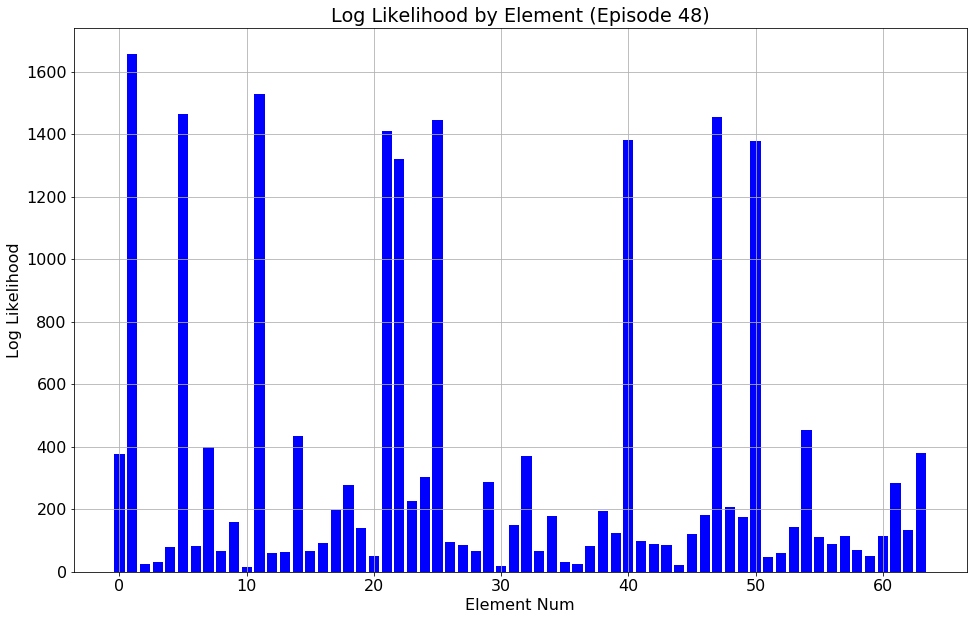

In [29]:
# Visualize log likelihood before traning
fig, ax = model.plot_bar('log_like', sorted=False)

In [32]:
# Adaptive search parameters
max_batches_mixture = 2000
max_batches_element = 10000
batches_per_epoch = 100
epochs_per_episode = 5
max_bad_episodes = 3
min_learning_rate = None
save_at_end = False
reset_active_weight = False
verbose = 1

In [28]:
# Load model
model.load()
model.report()

     \  log_like :  hits  :  R_deg    :    R_sec
Mean :   328.06  :  23.84 :  0.413328 :  1487.98
Std  :   467.39  :  57.96 :  0.255180 :   918.65
Min  :    15.62  :   0.00 :  0.001767 :     6.36
Max  :  1656.96  : 189.99 :  1.000000 :  3600.00


In [31]:
# Preliminary round of training with frozen elements
model.freeze_candidate_elements()

In [33]:
# Train perturbed model with frozen orbital elements
model.search_adaptive(
    max_batches=max_batches_mixture, 
    batches_per_epoch=batches_per_epoch,
    epochs_per_episode=epochs_per_episode,
    reset_active_weight=reset_active_weight,
    verbose=verbose)


********************************************************************************
Terminating: Completed 17800 batches.
********************************************************************************


In [34]:
# Report after initial training on mixture parameters
model.report()

     \  log_like :  hits  :  R_deg    :    R_sec
Mean :   328.06  :  23.84 :  0.413328 :  1487.98
Std  :   467.39  :  57.96 :  0.255180 :   918.65
Min  :    15.62  :   0.00 :  0.001767 :     6.36
Max  :  1656.97  : 189.99 :  1.000000 :  3600.00


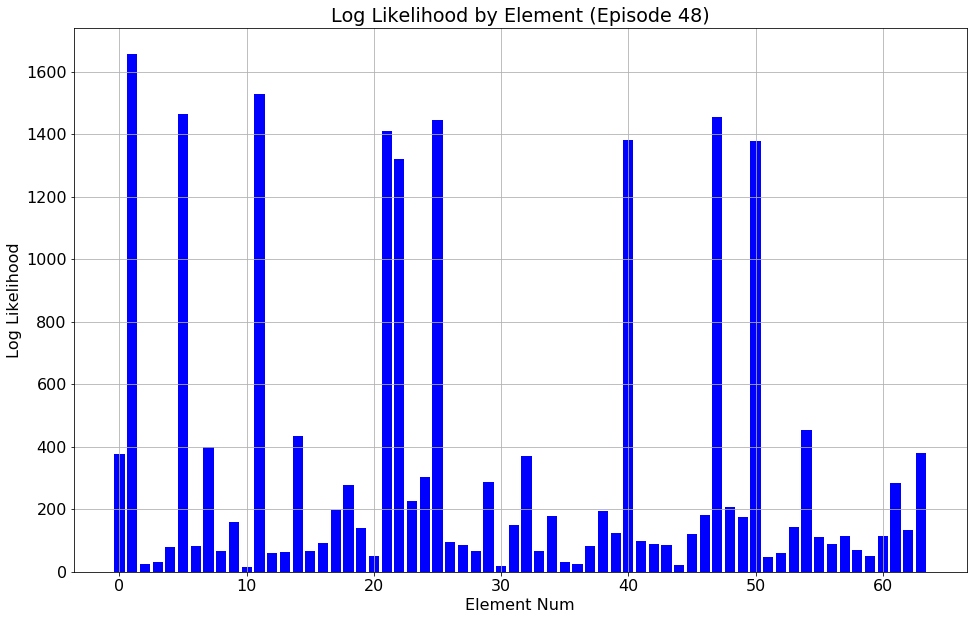

In [35]:
# Bar chart - log likelihood by element
fig, ax = model.plot_bar('log_like', sorted=False)

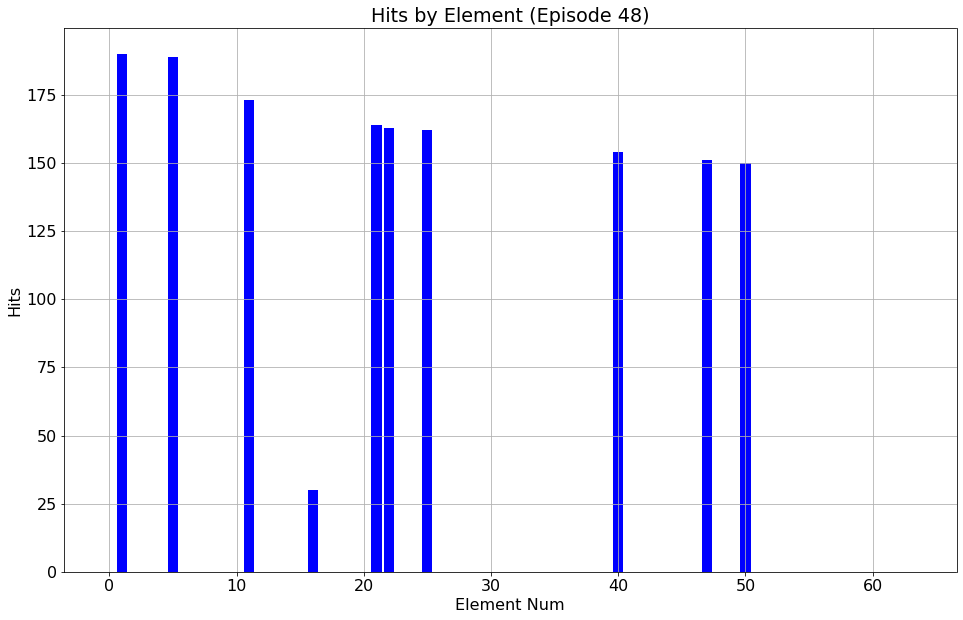

In [36]:
# Bar chart - log likelihood by element
fig, ax = model.plot_bar('hits', sorted=False)

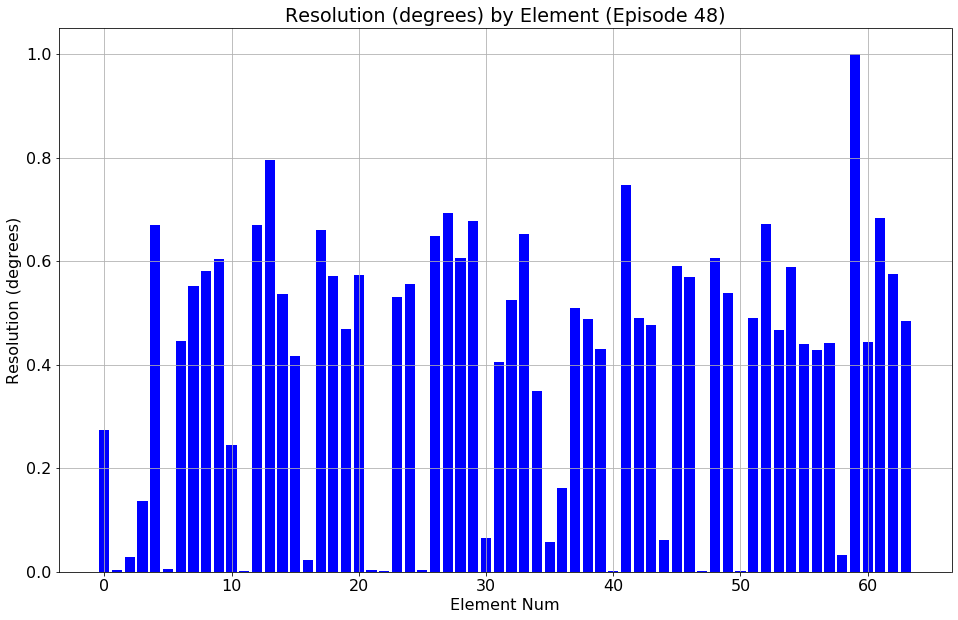

In [37]:
# Bar chart - log likelihood by element
fig, ax = model.plot_bar('R_deg', sorted=False)

## Train on Perturbed Model: Joint (Elements & Mixture)

In [38]:
# Unfreeze the elements, freeze the mixture model parameters
model.thaw_candidate_elements()

In [39]:
# New smaller learning rate
learning_rate = 2.0**-15

In [40]:
# Train unperturbed model in joint mode
model.search_adaptive(
    max_batches=max_batches_element, 
    batches_per_epoch=batches_per_epoch,
    epochs_per_episode=epochs_per_episode,
    learning_rate=learning_rate,
    reset_active_weight=reset_active_weight,
    verbose=verbose)


********************************************************************************
Terminating: Completed 17800 batches.
********************************************************************************


In [41]:
# Report after training
model.report()

     \  log_like :  hits  :  R_deg    :    R_sec
Mean :   328.06  :  23.84 :  0.413328 :  1487.98
Std  :   467.38  :  57.96 :  0.255180 :   918.65
Min  :    15.62  :   0.00 :  0.001767 :     6.36
Max  :  1656.97  : 189.99 :  1.000000 :  3600.00


In [42]:
# model.save_state()

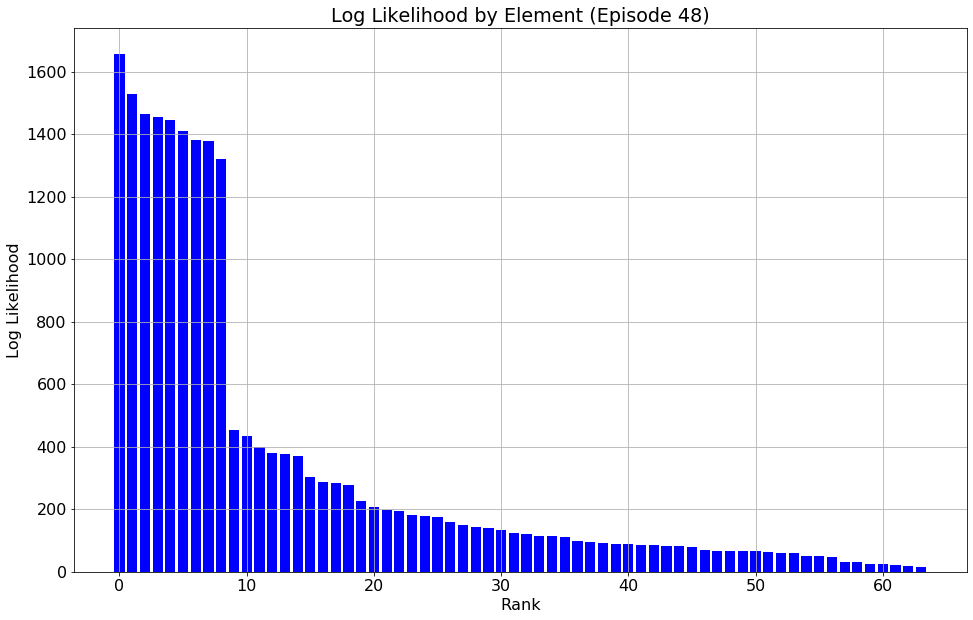

In [43]:
# Bar chart - log likelihood by element
fig, ax = model.plot_bar('log_like', sorted=True)

## Extended Training

In [45]:
max_batches_element_2 = 15000

In [46]:
# Train unperturbed model in joint mode
model.search_adaptive(
    max_batches=max_batches_element_2, 
    batches_per_epoch=batches_per_epoch,
    epochs_per_episode=epochs_per_episode,
    learning_rate=learning_rate,
    save_at_end=False,
    verbose=verbose)


********************************************************************************
Terminating: Completed 17800 batches.
********************************************************************************


In [47]:
model.report()

     \  log_like :  hits  :  R_deg    :    R_sec
Mean :   328.06  :  23.84 :  0.413328 :  1487.98
Std  :   467.39  :  57.96 :  0.255180 :   918.65
Min  :    15.62  :   0.00 :  0.001767 :     6.36
Max  :  1656.96  : 189.99 :  1.000000 :  3600.00


In [48]:
# model.save_state()

In [ ]:
model.search_adaptive(
    max_batches=100000, 
    batches_per_epoch=batches_per_epoch,
    epochs_per_episode=epochs_per_episode,
    learning_rate=2.0**-16,
    reset_active_weight=True,
    save_at_end=False,
    verbose=verbose)

In [ ]:
model.save_state()

## Review Results Graphically

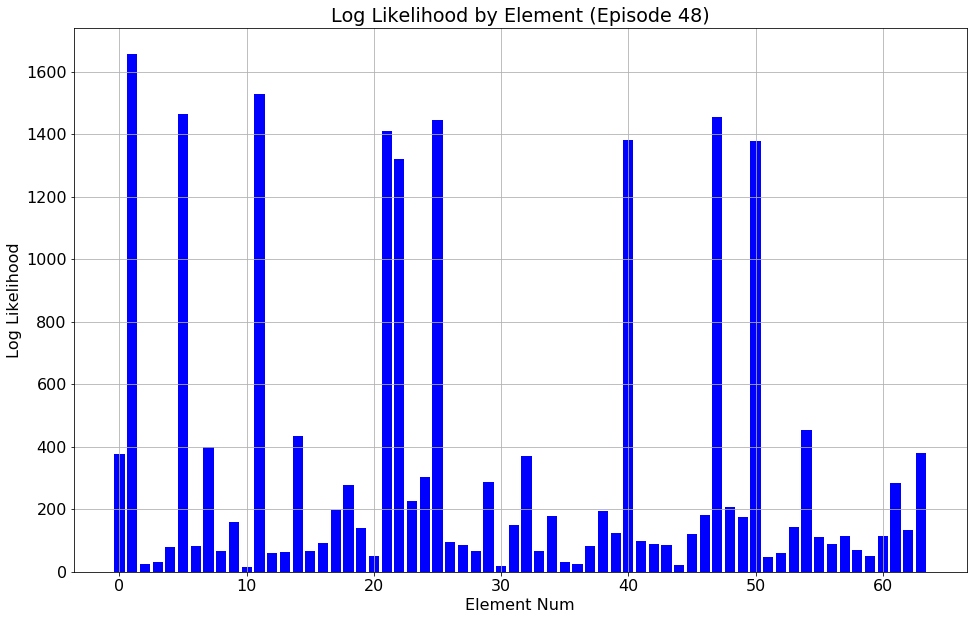

In [49]:
# Bar chart - log likelihood by element
fig, ax = model.plot_bar('log_like', sorted=False)

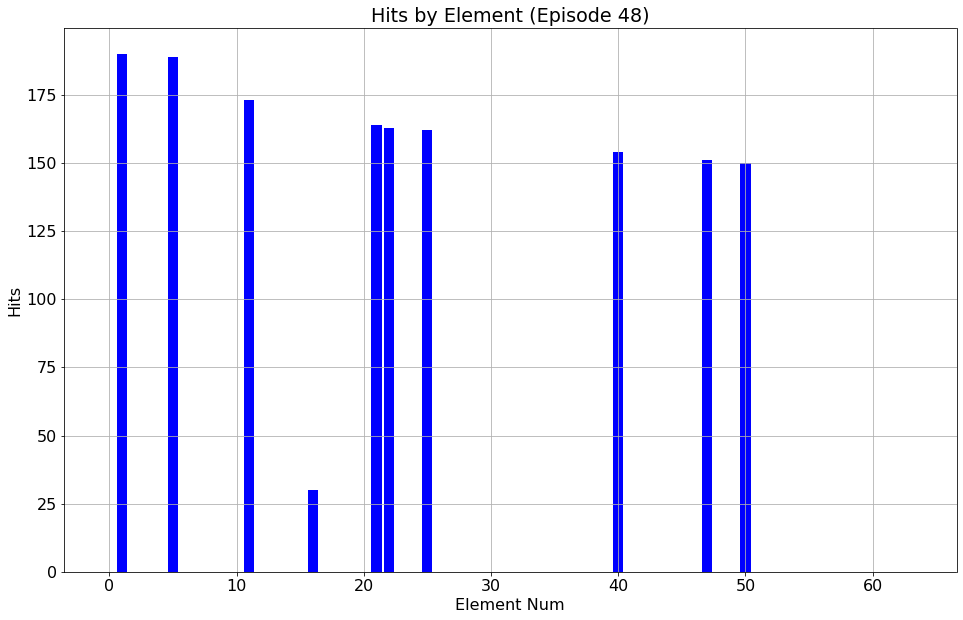

In [50]:
# Bar chart: hits
fig, ax = model.plot_bar('hits', sorted=False)

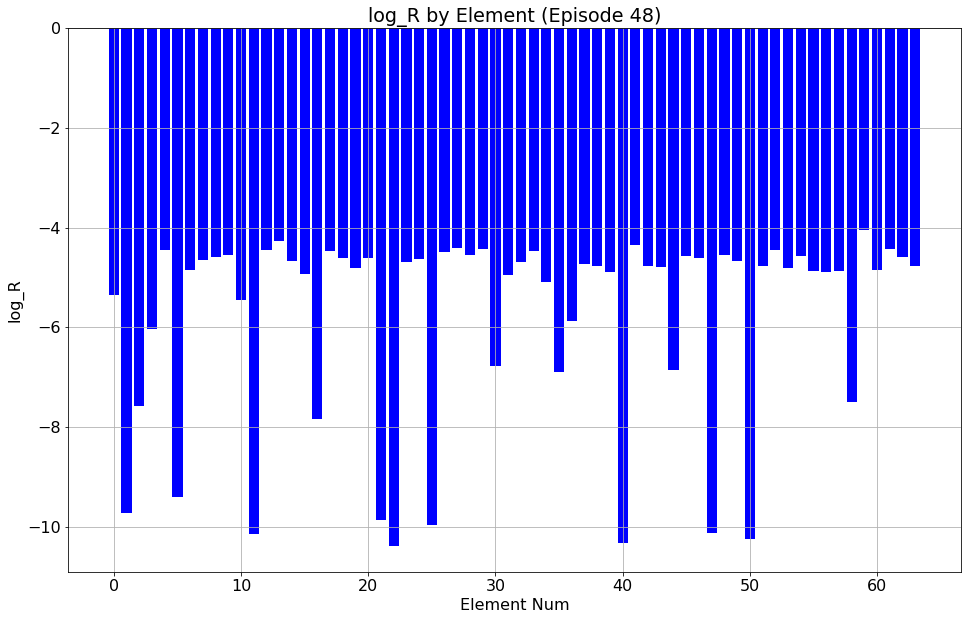

In [51]:
# Bar chart: log likelihood
fig, ax = model.plot_bar('log_R', sorted=False)

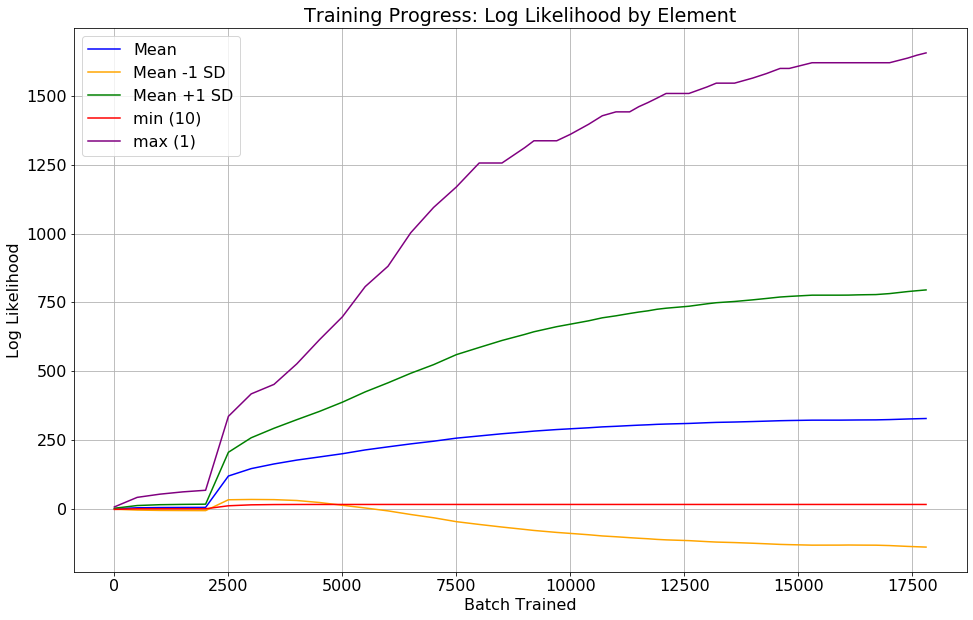

In [52]:
# Learning curve: log likelihood
fig, ax = model.plot_hist('log_like')

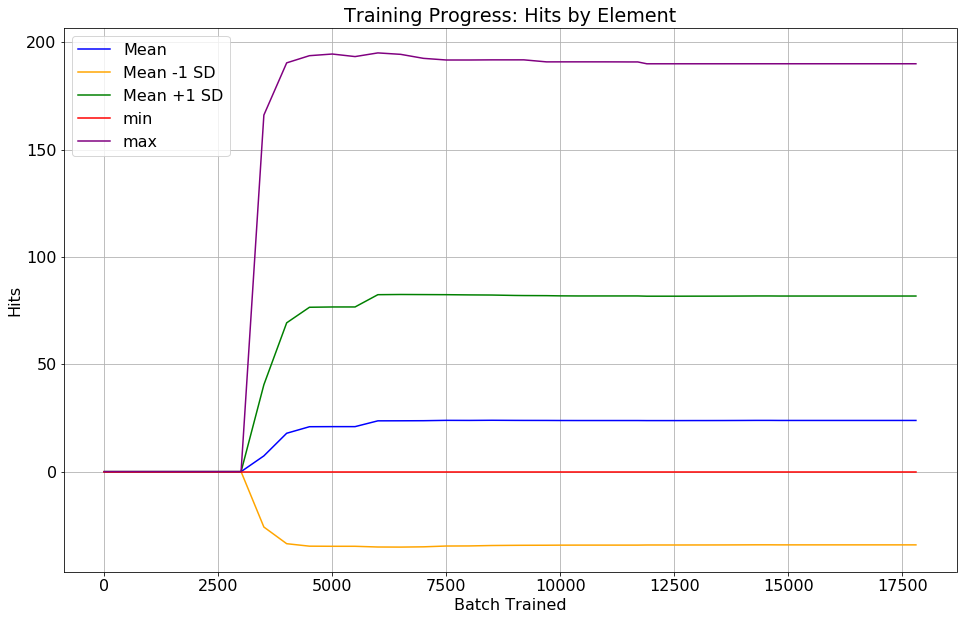

In [53]:
# Learning curve: hits
fig, ax = model.plot_hist('hits')

## Distance vs. Nearest Asteroid for Fitted Elements

In [54]:
# Find nearest asteroid to fitted elements
elts_fit, elts_near = model.nearest_ast()

In [62]:
# Review asteroids nearest to the fitted elements
elts_near

,element_id,nearest_ast_num,nearest_ast_name,nearest_ast_dist,a,e,inc,Omega,omega,f,epoch
0,51921,252633,2001 XQ213,0.012065,2.754397,0.238638,0.277118,4.545567,2.430909,-1.067569,58600.0
1,59244,59244,1999 CG6,0.000015,2.634727,0.262503,0.465045,5.738298,1.766995,-1.601363,58600.0
2,15786,425432,2010 DH49,0.004497,1.914492,0.049429,0.316276,6.125888,2.421193,-2.829302,58600.0
3,3904,1200534,2016 AY103,0.005551,2.762655,0.095991,0.157310,5.631935,2.311760,-1.511202,58600.0
4,142999,75304,1999 XT36,0.012843,2.515427,0.118579,0.143359,0.212099,0.754777,-1.021169,58600.0
...,...,...,...,...,...,...,...,...,...,...,...
59,11952,448447,2010 DA45,0.002622,2.361852,0.051474,0.114252,5.969263,3.427912,3.148574,58600.0
60,134815,1055736,2008 UK200,0.010577,2.330654,0.171818,0.423566,0.642391,6.125092,-0.312883,58600.0
61,27860,483660,2005 EM203,0.004273,2.467803,0.171377,0.135343,5.936276,3.179395,3.658047,58600.0
62,85937,230521,2002 WM11,0.007777,2.279547,0.182369,0.409267,4.900106,3.120242,-1.902370,58600.0


In [63]:
# Review fitted elements including nearest asteroid
elts_fit

,element_id,a,e,inc,Omega,omega,f,epoch,h,lam,R,R_deg,R_sec,log_like,hits,nearest_ast_num,nearest_ast_dist
0,51921,2.781029,0.235485,0.505872,4.700481,2.450142,-1.110119,58600.0,0.186917,26.694485,0.004777,0.273705,985.337708,376.797058,0.000000,252633,0.012065
1,59244,2.634685,0.262535,0.465036,5.738266,1.767394,-1.601668,58600.0,0.096405,168686.218750,0.000060,0.003443,12.395259,1656.967529,189.988953,59244,0.000015
2,15786,1.919504,0.045430,0.380038,6.132790,0.770572,-1.237745,58600.0,0.006214,2303.125000,0.000514,0.029467,106.080780,23.858526,0.000000,425432,0.004497
3,3904,2.762023,0.129375,0.256917,5.504221,2.190780,-1.378290,58600.0,0.025700,108.362350,0.002371,0.135848,489.053436,30.481386,0.000000,1200534,0.005551
4,142999,2.507078,0.192001,0.493747,0.204743,0.910839,-1.334545,58600.0,0.160103,4.445196,0.011706,0.670733,2414.640381,79.079201,0.000000,75304,0.012843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,11952,2.362820,0.080151,0.126546,0.108262,2.865271,-3.026295,58600.0,0.188188,1.999846,0.017453,1.000000,3600.001221,49.852413,0.000000,448447,0.002622
60,134815,2.327252,0.089129,0.500497,0.244371,0.609253,-0.919936,58600.0,0.159030,10.161054,0.007743,0.443634,1597.081787,114.109924,0.000000,1055736,0.010577
61,27860,2.474122,0.152741,0.188445,5.510592,3.364067,3.859255,58600.0,0.247560,4.274328,0.011938,0.684009,2462.430908,284.120605,0.000000,483660,0.004273
62,85937,2.263040,0.205696,0.442214,5.238984,3.063836,4.053992,58600.0,0.198196,6.032692,0.010049,0.575757,2072.724854,134.696777,0.000000,230521,0.007777


In [64]:
# Filter for only the good ones
mask = (elts_fit.log_like > 200) & (elts_fit.R_sec < 60)
elts_fit[mask]

,element_id,a,e,inc,Omega,omega,f,epoch,h,lam,R,R_deg,R_sec,log_like,hits,nearest_ast_num,nearest_ast_dist
1,59244,2.634685,0.262535,0.465036,5.738266,1.767394,-1.601668,58600.0,0.096405,168686.218750,0.000060,0.003443,12.395259,1656.967529,189.988953,59244,0.000015
5,5817,2.407693,0.340320,0.368377,5.942306,1.445873,-1.737711,58600.0,0.071655,88753.398438,0.000083,0.004747,17.088459,1465.750244,188.971222,5817,0.000005
11,9936,3.080125,0.185431,0.268931,5.416924,0.245393,0.722379,58600.0,0.047486,397082.281250,0.000039,0.002244,8.078956,1529.403198,172.991150,9936,0.000101
21,77774,3.203304,0.152664,0.424120,5.821392,0.027923,0.724900,58600.0,0.097326,229767.703125,0.000051,0.002950,10.620646,1411.883789,163.988800,77774,0.000746
22,9229,2.907927,0.069681,0.018452,4.883329,2.920561,-1.045092,58600.0,0.014338,640541.250000,0.000031,0.001767,6.360949,1322.053711,162.982071,9229,0.000041
25,203722,3.171169,0.291648,0.426091,5.309555,1.789325,-1.162641,58600.0,0.072293,278955.156250,0.000047,0.002677,9.638917,1445.580688,161.992432,203722,0.000004
40,31539,3.216990,0.179298,0.297359,5.773879,5.041402,1.786662,58600.0,0.050600,571318.687500,0.000033,0.001871,6.735289,1381.766968,153.992477,31539,0.000640
47,733,3.399169,0.059346,0.354064,5.951512,3.310434,3.708608,58600.0,0.107997,375045.187500,0.000040,0.002309,8.312921,1456.513794,150.996628,733,0.000106
50,6455,2.240791,0.572583,0.651760,0.470412,4.585705,0.184837,58600.0,0.054131,490648.593750,0.000035,0.002019,7.267920,1378.044067,149.994476,6455,0.000034


In [65]:
# Filter for incomplete convergence
mask = (elts_fit.log_like > 200) & (elts_fit.R_sec >= 60)
elts_fit[mask]

,element_id,a,e,inc,Omega,omega,f,epoch,h,lam,R,R_deg,R_sec,log_like,hits,nearest_ast_num,nearest_ast_dist
0,51921,2.781029,0.235485,0.505872,4.700481,2.450142,-1.110119,58600.0,0.186917,26.694485,0.004777,0.273705,985.337708,376.797058,0.0,252633,0.012065
7,5179,2.378005,0.035939,0.109192,5.688697,3.551187,3.282546,58600.0,0.180678,6.554204,0.009641,0.552376,1988.552856,398.669556,0.0,134261,0.002374
14,14692,2.772348,0.026116,0.151307,6.219309,2.005273,-1.661799,58600.0,0.215554,6.932127,0.009374,0.537108,1933.587280,435.830536,0.0,151856,0.003174
18,4133,2.431975,0.148647,0.200933,5.566833,4.528152,2.765035,58600.0,0.200172,6.120374,0.009977,0.571618,2057.823975,278.698730,0.0,33096,0.005131
23,49627,2.487216,0.012136,0.204594,0.535406,2.106946,-2.358718,58600.0,0.142074,7.121989,0.009248,0.529900,1907.639648,228.100250,0.0,1044262,0.005334
24,2015,2.411692,0.127523,0.217316,6.126064,4.790411,1.842289,58600.0,0.239038,6.484039,0.009693,0.555356,1999.283203,304.832520,0.0,244239,0.004926
29,17262,2.194453,0.099309,0.096726,5.358448,2.002529,-1.446376,58600.0,0.199939,4.359173,0.011821,0.677319,2438.349121,288.048645,0.0,224826,0.003293
32,19794,2.434273,0.101614,0.211332,0.432581,1.400249,-1.838446,58600.0,0.154424,7.254012,0.009164,0.525056,1890.200073,370.136627,0.0,19794,0.002399
48,10368,2.495443,0.109583,0.192586,6.276056,5.821679,0.385086,58600.0,0.166848,5.448591,0.010574,0.605833,2180.998291,206.363419,0.0,191147,0.005731
54,2294,2.593226,0.084220,0.094940,5.007183,0.902030,0.292566,58600.0,0.165368,5.769423,0.010276,0.588747,2119.489014,452.906464,0.0,2294,0.003902


## Visualize Error vs. Nearest Asteroid

In [66]:
model.elts_near_ast

,element_id,nearest_ast_num,nearest_ast_name,nearest_ast_dist,a,e,inc,Omega,omega,f,epoch
0,51921,252633,2001 XQ213,0.012065,2.754397,0.238638,0.277118,4.545567,2.430909,-1.067569,58600.0
1,59244,59244,1999 CG6,0.000015,2.634727,0.262503,0.465045,5.738298,1.766995,-1.601363,58600.0
2,15786,425432,2010 DH49,0.004497,1.914492,0.049429,0.316276,6.125888,2.421193,-2.829302,58600.0
3,3904,1200534,2016 AY103,0.005551,2.762655,0.095991,0.157310,5.631935,2.311760,-1.511202,58600.0
4,142999,75304,1999 XT36,0.012843,2.515427,0.118579,0.143359,0.212099,0.754777,-1.021169,58600.0
...,...,...,...,...,...,...,...,...,...,...,...
59,11952,448447,2010 DA45,0.002622,2.361852,0.051474,0.114252,5.969263,3.427912,3.148574,58600.0
60,134815,1055736,2008 UK200,0.010577,2.330654,0.171818,0.423566,0.642391,6.125092,-0.312883,58600.0
61,27860,483660,2005 EM203,0.004273,2.467803,0.171377,0.135343,5.936276,3.179395,3.658047,58600.0
62,85937,230521,2002 WM11,0.007777,2.279547,0.182369,0.409267,4.900106,3.120242,-1.902370,58600.0


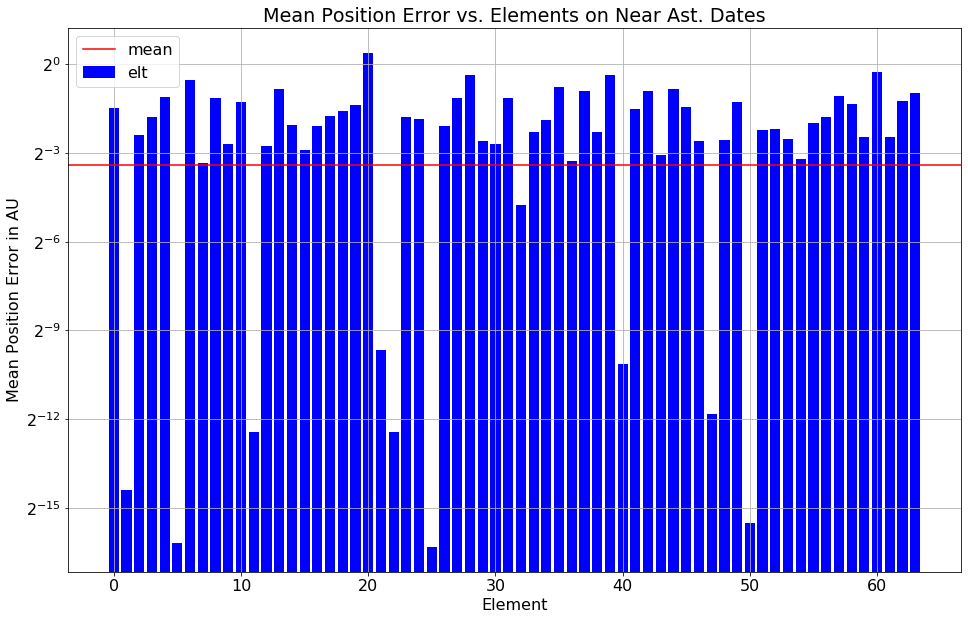

In [68]:
# Plot position error vs. known elements
fig, ax = model.plot_q_error(is_log=True, use_near_ast_dist=False)

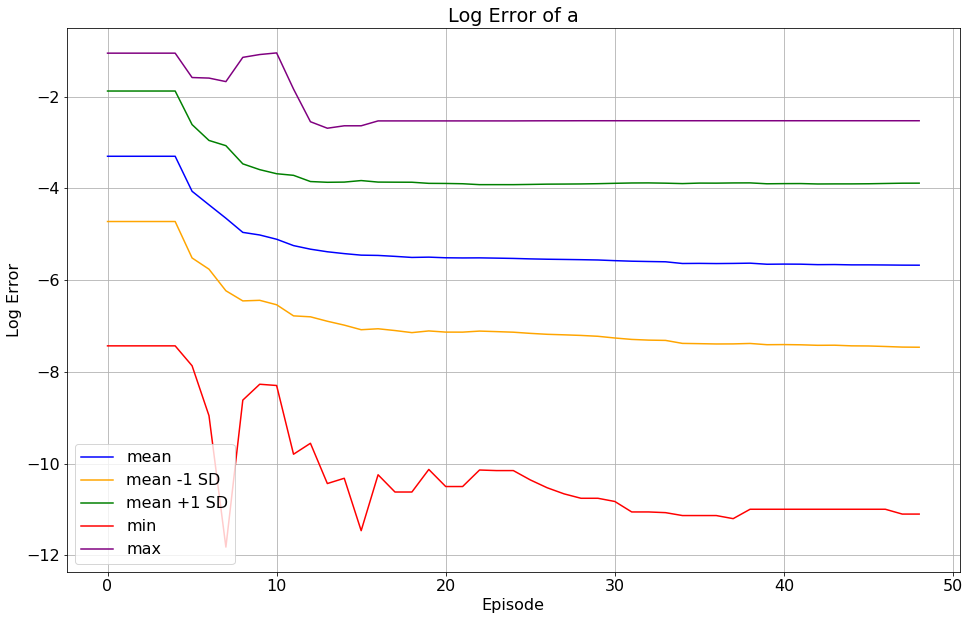

In [69]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error(elt_name='a', is_log=True, elt_num=None)

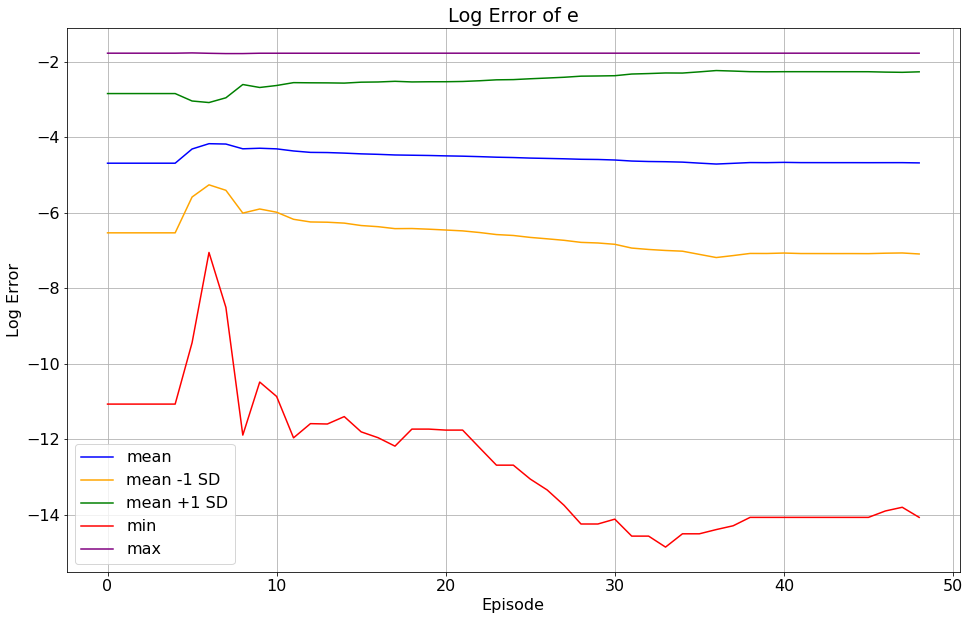

In [70]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error(elt_name='e', is_log=True, elt_num=None)